# Censored Data Models

[This example notebook on Bayesian survival
analysis](http://docs.pymc.io/notebooks/survival_analysis.html) touches on the
point of censored data. _Censoring_ is a form of missing-data problem, in which
observations greater than a certain threshold are clipped down to that
threshold, or observations less than a certain threshold are clipped up to that
threshold, or both. These are called right, left and interval censoring,
respectively. In this example notebook we consider interval censoring.

Censored data arises in many modelling problems. Two common examples are:

1. _Survival analysis:_ when studying the effect of a certain medical treatment
   on survival times, it is impossible to prolong the study until all subjects
   have died. At the end of the study, the only data collected for many patients
   is that they were still alive for a time period $T$ after the treatment was
   administered: in reality, their true survival times are greater than $T$.

2. _Sensor saturation:_ a sensor might have a limited range and the upper and
   lower limits would simply be the highest and lowest values a sensor can
   report. For instance, many mercury thermometers only report a very narrow
   range of temperatures.

This example notebook presents two different ways of dealing with censored data
in PyMC3:

1. An imputed censored model, which represents censored data as parameters and
   makes up plausible values for all censored values. This produces as a
   byproduct a plausible set of made up values that would have been censored.
   Each censored element introduces a random variable.

2. An unimputed censored model, where the censored data are integrated out and
   accounted for only through the log-likelihood. This method deals more
   adequately with large amounts of censored data and converges more quickly.

To establish a baseline we compare to an uncensored model of the uncensored
data.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

sns.set_style('whitegrid')

In [30]:
# Produce normally distributed samples
np.random.seed(1618)
size = 500
mu = 13.
sigma = 5.
samples = np.random.normal(mu, sigma, size)

# Set censoring limits
high = 16.
low = -1.

# Censor samples
censored = samples[(samples > low) & (samples < high)]

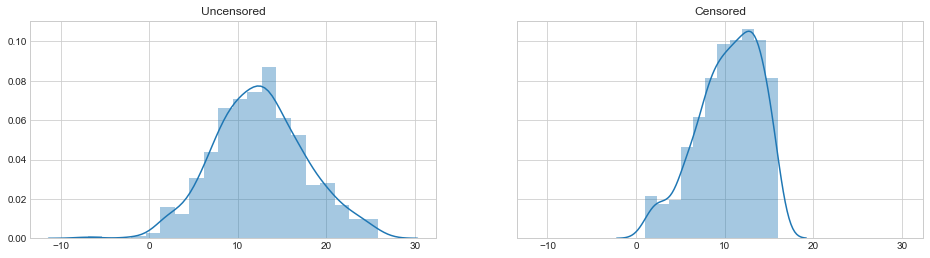

In [31]:
# Visualize uncensored and censored data
_, axarr = plt.subplots(ncols=2, figsize=[16, 4], sharex=True, sharey=True)
for i, data in enumerate([samples, censored]):
    sns.distplot(data, ax=axarr[i])
axarr[0].set_title('Uncensored')
axarr[1].set_title('Censored')
plt.show()

## Baseline - Uncensored Model of Uncensored Data

In [32]:
# Uncensored model
with pm.Model() as uncensored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=samples)

## Model 1 - Imputed Censored Model of Censored Data

This model makes use of [PyMC3's bounded variables](https://docs.pymc.io/api/bounds.html).

In [33]:
# Imputed censored model
# Keep tabs on left/right censoring

n_right_censored = len(samples[samples >= high])
n_left_censored = len(samples[samples <= low])
n_observed = len(samples) - n_right_censored - n_left_censored

with pm.Model() as imputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    right_censored = pm.Bound(pm.Normal, lower=high)(
        'right_censored', mu=mu, sd=sigma, shape=n_right_censored
    )
    left_censored = pm.Bound(pm.Normal, upper=low)(
        'left_censored', mu=mu, sd=sigma, shape=n_left_censored
    )
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=censored,
        shape=n_observed
    )

## Model 2 - Unimputed Censored Model of Censored Data

This model makes use of [PyMC3's `Potential`](https://docs.pymc.io/api/model.html#pymc3.model.Potential).

In [4]:
# Helper functions
def normal_lcdf(mu, sigma, x):
    z = (x - mu) / sigma
    return tt.switch(
        tt.lt(z, -1.0),
        tt.log(tt.erfcx(-z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2,
        tt.log1p(-tt.erfc(z / tt.sqrt(2.)) / 2.)
    )


def normal_lccdf(mu, sigma, x):
    z = (x - mu) / sigma
    return tt.switch(
        tt.gt(z, 1.0),
        tt.log(tt.erfcx(z / tt.sqrt(2.)) / 2) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(-z / tt.sqrt(2.)) / 2.)
    )

def censored_right_likelihood(mu, sigma, n_right_censored, upper_bound):
    return n_right_censored * normal_lccdf(mu, sigma, upper_bound)


def censored_left_likelihood(mu, sigma, n_left_censored, lower_bound):
    return n_left_censored * normal_lcdf(mu, sigma, lower_bound)

In [7]:
# Unimputed censored model
with pm.Model() as unimputed_censored_model:
    mu = pm.Normal('mu', mu=0., sd=(high - low) / 2.)
    sigma = pm.HalfNormal('sigma', sd=(high - low) / 2.)
    observed = pm.Normal(
        'observed',
        mu=mu,
        sd=sigma,
        observed=truncated,
    )
    right_censored = pm.Potential(
        'right_censored',
        censored_right_likelihood(mu, sigma, n_right_censored, high)
        )
    left_censored = pm.Potential(
        'left_censored',
        censored_left_likelihood(mu, sigma, n_left_censored, low)
    )


## Sampling

In [9]:
n = 1500

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Model with no censored data (omniscient)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1591.09it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '2988' (I am process '2989')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/preich/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2988' (I am process '2990')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/preich/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2989' (I am process '2990')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/preich/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir


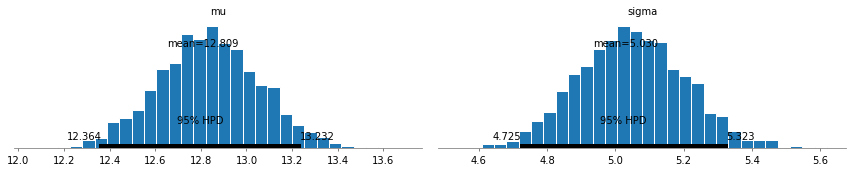

In [ ]:
print('Model with no censored data (omniscient)')
with omniscient_model:
    trace = pm.sample(n)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])
    plt.show()

In [ ]:
print('Imputed censored model')
with imputed_censored_model:
    trace = pm.sample(n)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Imputed censored model


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [left_censored_upperbound__, right_censored_lowerbound__, sigma_log__, mu]
 16%|█▌        | 324/2000 [00:02<00:13, 124.70it/s]

In [ ]:
print('Unimputed censored model')
with unimputed_censored_model:
    trace = pm.sample(n)
    pm.plot_posterior(trace[-1000:], varnames=['mu', 'sigma'])
    plt.show()